# ER+ breast cancer effective graph

> A.J. Gates, R.B. Correia, X. Wang, & L.M. Rocha [2021]. "The effective graph reveals redundancy, canalization, and control pathways in biochemical regulation and signaling". Proceedings of the National Academy of Sciences (PNAS), 118 (12).

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import graphviz
# Cana
from cana.datasets.bio import BREAST_CANCER
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Networkx
import networkx as nx

In [2]:
def calculates_path_length(G, path, weight='weight'):
    path_weight_sum = 0.0
    weakest_link = np.inf
    for source, target in zip(path[:-1], path[1:]):
        edge_weight = G.edges[(source, target)][weight]
        path_weight_sum += edge_weight
        if edge_weight < weakest_link:
            weakest_link = edge_weight
    return path_weight_sum, weakest_link

In [3]:
C = BREAST_CANCER()

In [4]:
SG = C.structural_graph()
EG = C.effective_graph(threshold=-1)
#
EG0 = C.effective_graph(threshold=0)
EG0p2 = C.effective_graph(threshold=.2)
EG0p4 = C.effective_graph(threshold=.4)

In [5]:
pd.options.display.float_format = '{:.2g}'.format
#
df = pd.DataFrame({
        'node':[n.name for n in C.nodes],
        'k':[n.k for n in C.nodes],
        'k_r':[n.input_redundancy(norm=False) for n in C.nodes],
        'k_e':[n.effective_connectivity(norm=False) for n in C.nodes],
        'k_r*':[n.input_redundancy(norm=True) for n in C.nodes],
        'k_e*':[n.effective_connectivity(norm=True) for n in C.nodes],
        'k^{out}':[v for n,v in EG.out_degree()],
        'k_e^{out}':[v for n,v in EG.out_degree(weight='weight')],
    })
#df = df[['k','k_r','k_e','k_r*','k_e*','k^{out}','k_e^{out}']]
df['k_e^{out}/k^{out}'] = df['k_e^{out}'] / df['k^{out}']
df.sort_values('k',ascending=False,inplace=True)
#print(df.to_latex(escape=False))
#
drugs = [3, 4, 5, 6, 7, 8, 9]
dfd = df.loc[drugs, ['node', 'k^{out}', 'k_e^{out}', 'k_e^{out}/k^{out}']]
dfd.sort_values(['k^{out}', 'k_e^{out}'], ascending=[False, False], inplace=True)
display(dfd)

,node,k^{out},k_e^{out},k_e^{out}/k^{out}
5,Everolimus,4,3.2,0.81
4,Alpelisib,3,1.9,0.64
3,Fulvestrant,3,1.8,0.6
9,Neratinib,3,1.6,0.54
6,Trametinib,3,1.5,0.49
8,Palbociclib,2,2,1
7,Ipatasertib,2,1.3,0.65


In [6]:
def number_of_input_nodes(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [] or inputs == [True]:
            count += 1
    return count
#
def number_of_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if any(inputs):
            count += 1
    return count
#
def number_of_input_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [True]:
            count += 1
    return count

In [7]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)')]:
    n_nodes = G.number_of_nodes()
    print('{g:s}: Number of nodes: {n:d}'.format(g=graph, n=n_nodes))
    n_nodes_with_self_loop = number_of_nodes_with_self_loop(G)
    print('{g:s}: Number nodes with a self-loop: {n:d}'.format(g=graph, n=n_nodes_with_self_loop))
    n_input_nodes = number_of_input_nodes(G)
    print('{g:s}: Number of input nodes: {n:d}'.format(g=graph, n=n_input_nodes))
    n_input_nodes_with_self_loop = number_of_input_nodes_with_self_loop(G)
    print('{g:s}: Number of input nodes with self-loop: {n:d}'.format(g=graph, n=n_input_nodes_with_self_loop))
    print('--')

IG: Number of nodes: 80
IG: Number nodes with a self-loop: 23
IG: Number of input nodes: 18
IG: Number of input nodes with self-loop: 18
--
EG: Number of nodes: 80
EG: Number nodes with a self-loop: 23
EG: Number of input nodes: 18
EG: Number of input nodes with self-loop: 18
--
EG (0.2): Number of nodes: 80
EG (0.2): Number nodes with a self-loop: 22
EG (0.2): Number of input nodes: 21
EG (0.2): Number of input nodes with self-loop: 19
--
EG (0.4): Number of nodes: 80
EG (0.4): Number nodes with a self-loop: 22
EG (0.4): Number of input nodes: 29
EG (0.4): Number of input nodes with self-loop: 20
--


In [8]:
def weakly_connected_components(G):
    wcc = [len(cc) for cc in nx.weakly_connected_components(G)]
    return len(wcc), wcc
#
def strongly_connected_components(G):
    scc = [len(cc) for cc in nx.strongly_connected_components(G)]
    return len(scc), scc
#
def SortedCounter(L):
    c = dict(sorted(Counter(L).most_common(), reverse=True)) 
    return c

In [9]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)')]:
    n_wcc, wcc = weakly_connected_components(G)
    print('{g:s}: {n:d} weakly connected components, sizes {l:}'.format(g=graph, n=n_wcc, l=SortedCounter(wcc)))
    #
    n_scc, scc = strongly_connected_components(G)
    print('{g:s}: {n:d} strongly connected components, sizes {l:}'.format(g=graph, n=n_scc, l=SortedCounter(scc)))
    print('--')

IG: 1 weakly connected components, sizes {80: 1}
IG: 45 strongly connected components, sizes {24: 1, 8: 1, 2: 5, 1: 38}
--
EG: 1 weakly connected components, sizes {80: 1}
EG: 45 strongly connected components, sizes {24: 1, 8: 1, 2: 5, 1: 38}
--
EG (0.2): 3 weakly connected components, sizes {78: 1, 1: 2}
EG (0.2): 52 strongly connected components, sizes {17: 1, 8: 1, 2: 5, 1: 45}
--
EG (0.4): 12 weakly connected components, sizes {52: 1, 13: 1, 4: 1, 3: 1, 1: 8}
EG (0.4): 70 strongly connected components, sizes {3: 1, 2: 8, 1: 61}
--


In [10]:
wcc = nx.weakly_connected_components(EG0p2)
for id,comp in enumerate(wcc):
    print('Component id={id:d} with size: {size:d}'.format(id=id, size=len(comp)))
    names = []
    for node in comp:
        name = G.nodes[node]['label']
        names.append(name)
    print(names)

Component id=0 with size: 78
['IGF1R_T', 'IGF1R', 'IGF1R_2', 'Fulvestrant', 'Alpelisib', 'Everolimus', 'Trametinib', 'Ipatasertib', 'Palbociclib', 'Neratinib', 'HER2', 'HER3_T', 'HER3', 'HER3_2', 'PDK1', 'mTORC2', 'SGK1_T', 'SGK1', 'PIM', 'HER2_3', 'HER2_3_2', 'RAS', 'RAS_2', 'RAS_3', 'MAPK', 'MAPK_2', 'PI3K', 'PI3K_2', 'PTEN', 'PIP3', 'PIP3_2', 'PDK1_pm', 'mTORC2_pm', 'AKT', 'p21_p27_T', 'p21_p27', 'cycE_CDK2_T', 'cycE_CDK2', 'KMT2D', 'TSC', 'PRAS40', 'mTORC1', 'FOXO3', 'FOXO3_Ub', 'BIM_T', 'BCL2_T', 'BIM', 'BAD', 'MCL1', 'EIF4F', 'S6K', 'Translation', 'ER', 'ESR1', 'ESR1_2', 'FOXA1', 'ER_transcription', 'ER_transcription_2', 'MYC', 'MYC_2', 'cyclinD', 'cyclinD_2', 'BCL2', 'CDK46', 'cycD_CDK46', 'cycD_CDK46_2', 'pRb', 'pRb_2', 'pRb_3', 'E2F', 'E2F_2', 'E2F_3', 'Proliferation', 'Proliferation_2', 'Proliferation_3', 'Proliferation_4', 'Apoptosis', 'Apoptosis_2']
Component id=1 with size: 1
['PBX1']
Component id=2 with size: 1
['Apoptosis_3']


In [11]:
# Print node names
for i,d in SG.nodes(data=True):
    print(i,d)

0 {'label': 'IGF1R_T'}
1 {'label': 'IGF1R'}
2 {'label': 'IGF1R_2'}
3 {'label': 'Fulvestrant'}
4 {'label': 'Alpelisib'}
5 {'label': 'Everolimus'}
6 {'label': 'Trametinib'}
7 {'label': 'Ipatasertib'}
8 {'label': 'Palbociclib'}
9 {'label': 'Neratinib'}
10 {'label': 'HER2'}
11 {'label': 'HER3_T'}
12 {'label': 'HER3'}
13 {'label': 'HER3_2'}
14 {'label': 'PDK1'}
15 {'label': 'mTORC2'}
16 {'label': 'SGK1_T'}
17 {'label': 'SGK1'}
18 {'label': 'PIM'}
19 {'label': 'HER2_3'}
20 {'label': 'HER2_3_2'}
21 {'label': 'RAS'}
22 {'label': 'RAS_2'}
23 {'label': 'RAS_3'}
24 {'label': 'MAPK'}
25 {'label': 'MAPK_2'}
26 {'label': 'PI3K'}
27 {'label': 'PI3K_2'}
28 {'label': 'PTEN'}
29 {'label': 'PIP3'}
30 {'label': 'PIP3_2'}
31 {'label': 'PDK1_pm'}
32 {'label': 'mTORC2_pm'}
33 {'label': 'AKT'}
34 {'label': 'p21_p27_T'}
35 {'label': 'p21_p27'}
36 {'label': 'cycE_CDK2_T'}
37 {'label': 'cycE_CDK2'}
38 {'label': 'KMT2D'}
39 {'label': 'TSC'}
40 {'label': 'PRAS40'}
41 {'label': 'mTORC1'}
42 {'label': 'FOXO3'}
43 {'

In [12]:
net_redundancy = 0
#
for nid, node in enumerate(C.nodes,start=0):
    net_redundancy += node.input_redundancy(norm=False)
#
net_redundancy_norm = net_redundancy / C.Nnodes
#
print("Total Network Redundancy: {:.4} (norm: {:.4})".format(net_redundancy, net_redundancy_norm))

Total Network Redundancy: 124.9 (norm: 1.561)


In [13]:
dict_effconn = {nid: node.effective_connectivity(norm=False) 
    for nid, node in enumerate(C.nodes, start=0) }
#
nx.set_node_attributes(EG, dict_effconn, 'effective_connectivity')

In [14]:
# Node Manual Positioning
idmap = {d['label']:i for i,d in SG.nodes(data=True)}
att = {}
colors = {
        'Apoptosis': '#b3dc66',
        'Proliferation': '#bfbcd9',
        'Drugs': '#d299ff',
        'ER signaling': '#d3d3d3',
        'mTORC1 pathway': '#ffb96c',
        'AKT pathway': '#8fd3c4',
        'MAPK pathway': '#ffffae',
        'PI3K pathway': '#7aa6cb',
        'RTK signaling': '#f18568'}

#Line 11
att['HER3_T'] = {'pos':'.25,11', 'type':'RTK signaling'}
att['HER3'] = {'pos':'1.5,11', 'type':'RTK signaling'}
att['HER3_2'] = {'pos':'2.7,11', 'type':'RTK signaling'}
att['IGF1R_T'] = {'pos':'3.9,11', 'type':'RTK signaling'}


# Line 10
att['Neratinib'] = {'pos':'0,10', 'type':'Drugs'}
att['Alpelisib'] = {'pos':'4.3,9', 'type':'Drugs'}
att['Fulvestrant'] = {'pos':'7.4,11', 'type':'Drugs', 'width':'0.9'}
att['HER2_3_2'] = {'pos':'1.25,10', 'type':'RTK signaling'}
att['HER2_3'] = {'pos':'2.5,10', 'type':'RTK signaling'}
att['HER2'] = {'pos':'3.8,10', 'type':'RTK signaling'}
att['IGF1R'] = {'pos':'5,11', 'type':'RTK signaling'}
att['IGF1R_2'] = {'pos':'5,10', 'type':'RTK signaling'}
att['ESR1'] = {'pos':'6.8,10', 'type':'ER signaling'}
att['ESR1_2'] = {'pos':'8,10', 'type':'ER signaling'}
att['FOXA1'] = {'pos':'9.2,10', 'type':'ER signaling'}
att['PBX1'] = {'pos':'10.7,8', 'type':'ER signaling'}
# Line 9
att['Trametinib'] = {'pos':'0,9', 'type':'Drugs', 'width':'0.9'}
att['PI3K'] = {'pos':'3,9', 'type':'PI3K pathway'}
att['Everolimus'] = {'pos':'8,6', 'type':'Drugs', 'width':'0.9'}
att['Ipatasertib'] = {'pos':'6.0,9', 'type':'Drugs', 'width':'0.9'}
att['ER'] = {'pos':'8.5,9', 'type':'ER signaling'}

#Line 8
att['MAPK'] = {'pos':'0.2,8', 'type':'MAPK pathway'}
att['PI3K_2'] = {'pos':'3.0,8', 'type':'PI3K pathway'}
att['PIP3'] = {'pos':'4.3,8', 'type':'PI3K pathway'}
att['PIP3_2'] = {'pos':'4.3,7', 'type':'PI3K pathway'}
att['PTEN'] = {'pos':'3.0,7', 'type':'PI3K pathway'}
att['ER_transcription'] = {'pos':'7.6,8', 'type':'ER signaling', 'width':'1.3'}
att['ER_transcription_2'] = {'pos':'9.4,8', 'type':'ER signaling', 'width':'1.5'}

# Line 7
att['MAPK_2'] = {'pos':'0,7', 'type':'MAPK pathway'}
att['RAS'] = {'pos':'1.5,9', 'type':'MAPK pathway'}
att['RAS_2'] = {'pos':'1.5,7', 'type':'MAPK pathway'}
att['RAS_3'] = {'pos':'1.5,8', 'type':'MAPK pathway'}
att['PDK1_pm'] = {'pos':'4.5,6', 'type':'AKT pathway'}
att['mTORC2_pm'] = {'pos':'6.25,7', 'type':'AKT pathway', 'width':'1.2'}
att['KMT2D'] = {'pos':'9,7', 'type':'ER signaling'}
att['MYC'] = {'pos':'10,7', 'type':'ER signaling'}
att['MYC_2'] = {'pos':'11.2,7', 'type':'ER signaling'}
# Line 6
att['PDK1'] = {'pos':'0.5,6', 'type':'AKT pathway'}
att['mTORC2'] = {'pos':'1.75,6', 'type':'AKT pathway'}
att['PIM'] = {'pos':'3,6', 'type':'AKT pathway'}
att['AKT'] = {'pos':'6,6', 'type':'AKT pathway'}
att['Palbociclib'] = {'pos':'9.7,6', 'type':'Drugs', 'width':'0.9'}
# Line 5
att['SGK1_T'] = {'pos':'0.25,5', 'type':'AKT pathway'}
att['SGK1'] = {'pos':'1.5,5', 'type':'AKT pathway'}
att['TSC'] = {'pos':'5.5,5', 'type':'mTORC1 pathway'}
att['p21_p27'] = {'pos':'7,5', 'type':'Proliferation'}
att['p21_p27_T'] = {'pos':'8,5', 'type':'Proliferation'}
att['CDK46'] = {'pos':'9,5', 'type':'Proliferation'}
att['cyclinD'] = {'pos':'10.25,5', 'type':'Proliferation'}
# Line 4
att['FOXO3_Ub'] = {'pos':'1.3,4', 'type':'AKT pathway', 'width':'0.9'}
att['FOXO3'] = {'pos':'2.75,4', 'type':'AKT pathway'}
att['cycE_CDK2'] = {'pos':'6.5,4', 'type':'Proliferation', 'width':'1.0'}
att['cycE_CDK2_T'] = {'pos':'7.8,4', 'type':'Proliferation', 'width':'1.2'}
att['PRAS40'] = {'pos':'4,4', 'type':'mTORC1 pathway'}
att['mTORC1'] = {'pos':'5,4', 'type':'mTORC1 pathway'}
att['cycD_CDK46'] = {'pos':'9.2,4', 'type':'Proliferation', 'width': '1.0'}
att['cycD_CDK46_2'] = {'pos':'11.0,4', 'type':'Proliferation', 'width': '1.4'}
# Line 3
att['BIM_T'] = {'pos':'.5,3', 'type':'Apoptosis'}
att['BCL2_T'] = {'pos':'2,3', 'type':'Apoptosis'}
att['EIF4F'] = {'pos':'4,3', 'type':'mTORC1 pathway'}
att['S6K'] = {'pos':'5,3', 'type':'mTORC1 pathway'}
att['pRb'] = {'pos':'7.0,3', 'type':'Proliferation'}
att['pRb_2'] = {'pos':'8.25,3', 'type':'Proliferation'}
att['pRb_3'] = {'pos':'9.5,3', 'type':'Proliferation'}
att['cyclinD_2'] = {'pos':'10.5,3', 'type':'Proliferation'}
# Line 2
att['BIM'] = {'pos':'0,2', 'type':'Apoptosis'}
att['BAD'] = {'pos':'1,2', 'type':'Apoptosis'}
att['BCL2'] = {'pos':'2,2', 'type':'Apoptosis'}
att['MCL1'] = {'pos':'3,2', 'type':'Apoptosis'}
att['Translation'] = {'pos':'4.5,2', 'type':'mTORC1 pathway', 'width':'0.9'}
att['E2F'] = {'pos':'7.0,2', 'type':'Proliferation'}
att['E2F_2'] = {'pos':'8.25,2', 'type':'Proliferation'}
att['E2F_3'] = {'pos':'9.5,2', 'type':'Proliferation'}
# Line 1
att['Apoptosis'] = {'pos':'0.2,1', 'type':'Apoptosis', 'width':'1.0'}
att['Apoptosis_2'] = {'pos':'1.5,1', 'type':'Apoptosis', 'width':'1.0'}
att['Apoptosis_3'] = {'pos':'2.8,1', 'type':'Apoptosis', 'width':'1.0'}
att['Proliferation'] = {'pos':'6.5,1', 'type':'Proliferation', 'width':'1.1'}
att['Proliferation_2'] = {'pos':'7.9,1', 'type':'Proliferation', 'width':'1.1'}
att['Proliferation_3'] = {'pos':'9.3,1', 'type':'Proliferation', 'width':'1.1'}
att['Proliferation_4'] = {'pos':'10.7,1', 'type':'Proliferation', 'width':'1.1'}

# Check if overlapping nodes
poschk = set()
for k,v in att.items():
    if v['pos'] in poschk:
        raise TypeError("Overlapping nodes: {k:s}".format(k=k))
    else:
        poschk.add(v['pos'])

# Inverse Map
att = {idmap[k]:v for k,v in att.items()}

## Interaction Graph

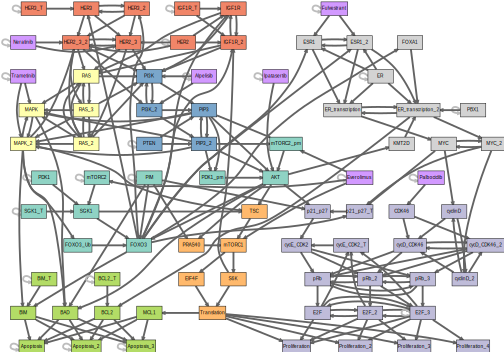

In [15]:
pSG = graphviz.Digraph(name='Structural Graph', engine='neato')
pSG.attr('graph', size='7,7', concentrate='false', simplify='false', overlap='true',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pSG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', style='filled', fillcolor='#515660', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='4')

for nid,SGatt in SG.nodes(data=True):
    label = SGatt['label']
    if nid in att:
        pos = att[nid].get('pos', '')
        shape = att[nid].get('shape', 'box')
        fillcolor = colors[att[nid].get('type')]
        #width = ''att[nid].get('width', '0.7')
        pSG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor, )

max_penwidth = 4
for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    # self loop color
    if uid == vid:
        color = '#bdbdbd'
        uid = uid + ':w'
        vid = vid + ':c'
    else:
        color = '#636363'
    pSG.edge(uid, vid, weight=weight, color=color)
    
display(pSG)
# Export
#pSG.render("BreastCancer-IG", cleanup=True)

## Effective Graph

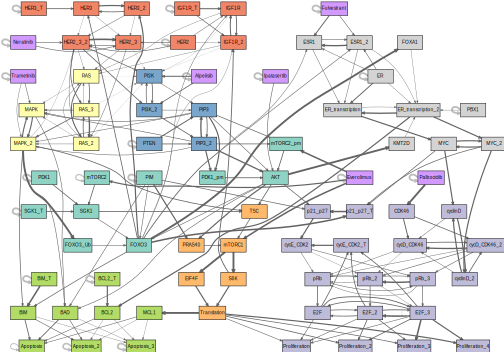

In [16]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='7,7', concentrate='false', simplify='false', overlap='true',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', style='filled', fillcolor='#515660', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='4')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
for nid,d in EG.nodes(data=True):
    label = d['label']
    ntype = att[nid].get('type')
    pos = att[nid].get('pos', '')
    shape = att[nid].get('shape')
    fillcolor = colors[ntype]
    pEG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0:       
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pEG.edge(uid,vid, style='dashed', color='#A90533')
    
display(pEG)
# Export
#pEG.render("BreastCancer-EG", cleanup=True)

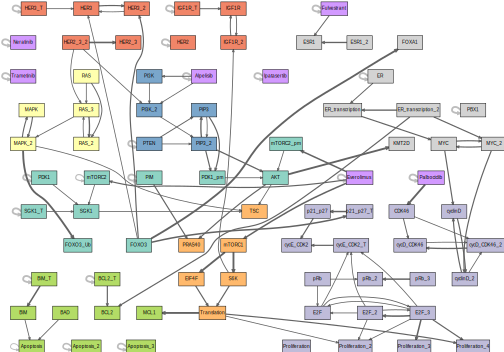

In [17]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='7,7', concentrate='false', simplify='false', overlap='true',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', style='filled', fillcolor='#515660', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='4')

max_effoutdegree = max([v for n,v in EG0p2.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
for nid,d in EG0p4.nodes(data=True):
    label = d['label']
    ntype = att[nid].get('type')
    pos = att[nid].get('pos', '')
    shape = att[nid].get('shape')
    fillcolor = colors[ntype]
    pEG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in EG0p4.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0.4:       
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pEG.edge(uid,vid, style='dashed', color='#A90533')
    
display(pEG)
# Export
#pEG.render("BreastCancer-EGt0p4", cleanup=True)

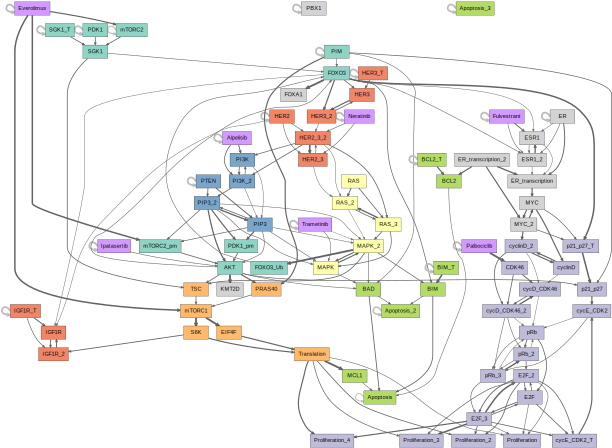

In [18]:
pEG = graphviz.Digraph(name='Structural Graph', engine='dot')
pEG.attr('graph', size='8.5,9', concentrate='false', simplify='false', overlap='false',splines='true',ratio='compress',outputorder="edgesfirst",nodesep='.25',ranksep='.25')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false', color='black', style='filled', fillcolor='#515660', penwidth='0.5', fontname='Helvetica', fontcolor='black',fontsize='12')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='3')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
cmap = LinearSegmentedColormap.from_list('custom', ['white','#d62728'])
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
norm = mpl.colors.Normalize(vmin=1, vmax=max_effoutdegree)
#
colornodes = ['Apoptosis', 'Apoptosis_2', 'Apoptosis_3', 'Proliferation', 'Proliferation_2', 'Proliferation_3', 'Proliferation_4']
#
# Manually position nodes using the DotLayout
dotpos = nx.drawing.nx_agraph.graphviz_layout(EG, prog='dot', args='-Gconcentrate=false -Gsimplify=false -Goverlap=false -Gsplines=True -Gratio=compress -Goutputorder=edgesfirst -Gnodesep=.25 -Granksep=.20')
#
for nid,d in EG.nodes(data=True):
    label = d['label']
    ntype = att[nid].get('type')
    x,y = dotpos[nid][0], dotpos[nid][1]
    pos = '{x:.2f},{y:.2f}'.format(x=x, y=y) #''#att[nid].get('pos', '')
    shape = att[nid].get('shape')
    fillcolor = colors[ntype]
    pEG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] >= 0.2:
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pass
        #pEG.edge(uid,vid, style='dashed', color='#A90533')
 
# Export
display(pEG)
#pEG.render("BreastCancer-EGt0p2-dotlayout", cleanup=True)

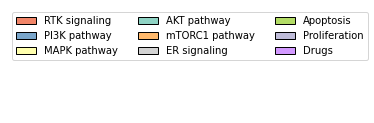

In [19]:
# Legend
from matplotlib.patches import Patch

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2,2))

labels = [
    'RTK signaling',
    'PI3K pathway',
    'MAPK pathway',
    'AKT pathway',
    'mTORC1 pathway',
    'ER signaling',
    'Apoptosis',
    'Proliferation',
    'Drugs']

handles = []
for label in labels:
    facecolor = colors[label]
    patch = Patch(facecolor=facecolor, edgecolor='black', label=label)
    handles.append(patch)

leg = ax.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
plt.axis('off')

plt.show()